<a id=top></a>
# Low Count Uncertainties in STIS <a class="tocSkip">

<h2>Learning Goals<span class="tocSkip"></span></h2>
By the end of this tutorial, you will:

- Understand how the `calstis` pipeline calculates uncertainties with the root-N approximation
- Know in what situations this approximation breaks down (i.e., low counts)
- Calculate more appropriate Poisson confidence intervals
- Compare uncertainties with STIS to those calculated for COS
- Know about a bug in the uncertainties calculated in `inttag` when making sub-exposures from TIME-TAG data

<div class="toc">
<ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="0-Introduction-0">0 Introduction</a></span></li></ul>
<ul class="toc-item"><li><span><a href="#Fetch-and-Read-In-Data" data-toc-modified-id="1-Fetch-and-Read-In-Data-1">1 Fetch and Read In Data</a></span></li></ul>
<ul class="toc-item"><li><span><a href="#Pipeline-Uncertainties" data-toc-modified-id="2-Pipeline-Uncertainties-2">2 Pipeline Uncertainties</a></span></li></ul>
<ul class="toc-item"><li><span><a href="#Poisson-Uncertainties" data-toc-modified-id="3-Poisson-Uncertainties-3">3 Poisson Uncertainties</a></span></li></ul>
<ul class="toc-item"><li><span><a href="#Poisson-Uncertainties-Applied-to-STIS" data-toc-modified-id="4-Poisson-Uncertainties-Applied-to-STIS-4">4 Poisson Uncertainties Applied to STIS</a></span></li></ul>
<ul class="toc-item"><li><span><a href="#New-stistools-Functionality" data-toc-modified-id="5-New-stistools-Functionality-5">5 New stistools Functionality</a><span></li></ul>
<ul class="toc-item"><li><span><a href="#Comparison-to-COS" data-toc-modified-id="6-Comparison-to-COS-6">6 Comparison to COS</a></span></li></ul>
<ul class="toc-item"><li><span><a href="#Recommendations" data-toc-modified-id="7-Recommendations-7">7 Recommendations</a></span></li></ul>
<ul class="toc-item"><li><span><a href="#Appendix:-INTTAG" data-toc-modified-id="Appendix:-INTTAG">Appendix: INTTAG</a></span></li></ul>
</div>

## Introduction
The root-N approximation for error calculation is ubiquitous in astronomy and is appropriate for a wide-range of observing scenarios. The root-N approximation means that the 1-$\sigma$ uncertainty associated with any measurement of counts (i.e., electrons on a CCD detector) can be approximated by just taking the square root of the number of counts, $N$. However, this approximation *does* break down for low counts $\lesssim10$ (inclusive of dark rate and read noise) sometimes seen in UV observations with instruments like HST/STIS and HST/COS.

In this notebook, we will look at where and why the root-N approximation breaks down, how the calculate appropriate Poisson confidence intervals, and how to apply that to HST/STIS observations. Some of these issues have been address in the HST/COS pipeline, CalCOS, so we compare to that in Section 5 as well.

For more information about calstis see:
- [STIS Calibration in the STIS Data Handbook](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration)
- [the `stistools` package documentation](https://stistools.readthedocs.io/en/latest/calstis.html)

### Import Necessary Packages
- `astropy.io.fits` for accessing FITS files
- `astroquery.mast.Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `os`, `shutil`, & `pathlib` for managing system paths
- `matplotlib` for plotting data
- `numpy` to handle array functions
- `stistools` for operations on STIS Data, including the new poisson_err.py
- `astropy.stats` and `scipy.stats` for the Poisson confidence interval function(s)

In [1]:
# Import for: Reading in fits file
from astropy.io import fits

# Import for: Downloading necessary files
# (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
import os
import shutil
import glob

# Import for: Plotting and specifying plotting parameters
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import for: Operations on STIS Data
import stistools

# Import numpy
import numpy as np

# Import astropy and scipy stat stuff
from astropy.stats import poisson_conf_interval
from scipy.stats import norm, poisson

# Import for shortened outputs
from IPython.display import clear_output

# Import for image display
from IPython.display import Image

# Using a colorblind friendly style
plt.style.use('tableau-colorblind10')

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/usr/share/miniconda/lib/python3.12/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/usr/share/miniconda/lib/python3.12/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


## Fetch and Read In Data
We're now going to fetch FUV observations to demonstrate where the root-N approximation breaks down. These observations are one orbit of a four-orbit transit time-series of HST/STIS/G140M that observed the Neptune-sized exoplanet GJ 436b transit across the disk of the M-dwarf host star, GJ 436. These observations were used to find hydrogen gas escaping from the planet's atmosphere in a comet-like tail ([Kulow et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...786..132K/abstract), [Ehrenreich et al. 2015](https://ui.adsabs.harvard.edu/abs/2015Natur.522..459E/abstract)).

In [2]:
# remove downlaod directory if it already exists
if os.path.exists("./mastDownload"):
    shutil.rmtree("./mastDownload")

# Search target object by obs_id
target_id = "obgh07020"
target = Observations.query_criteria(obs_id=[target_id])

# get a list of files assiciated with that target
target_list = Observations.get_product_list(target)

# download only the x1d file
Observations.download_products(target_list, extension='x1d.fits')

# get file path
file_path_obgh07020 = os.path.join(
                    'mastDownload', 'HST', target_id, f'{target_id}_x1d.fits')

# read in x1d
with fits.open(file_path_obgh07020) as hdu:
    header = hdu[0].header
    data = hdu[1].data
    exptime = hdu[1].header['EXPTIME']
    darkcount = hdu[1].header['MEANDARK']
    extrsize = hdu[1].data['EXTRSIZE']
    flux = hdu[1].data['FLUX'][0]
    flux_err = hdu[1].data['ERROR'][0]
    net = hdu[1].data['NET'][0]
    net_err = hdu[1].data['NET_ERROR'][0]
    gross = hdu[1].data['GROSS'][0]
    bg = hdu[1].data['BACKGROUND'][0]
    waves = hdu[1].data['WAVELENGTH'][0]

# Print some relevant information for reference...
print(hdu[0].header['TELESCOP'], hdu[0].header['INSTRUME'],
      hdu[0].header['DETECTOR'], hdu[0].header['OPT_ELEM'],
      hdu[0].header['APERTURE'])
print(f"Program: {hdu[0].header['PROPOSID']}")
print(f"PI: {hdu[0].header['PR_INV_F']} {hdu[0].header['PR_INV_M']} \
      {hdu[0].header['PR_INV_L']}")
print(f"Target: {hdu[0].header['TARGNAME']}")
print(f"Time: {hdu[0].header['TDATEOBS']} {hdu[0].header['TTIMEOBS']}")

 [Done]


HST STIS FUV-MAMA G140M 52X0.1
Program: 12034
PI: James Carswell       Green
Target: GJ436
Time: 2012-12-07 10:58:55


## Pipeline Uncertainties

Here, we will re-create the root-N approximated uncertainties calculated in the pipeline so that we can be sure of what the pipeline is doing. Let's first plot the data, just so we know what were dealing with:

In [3]:
# Let's plot the flux to see what's going on
fig, ax = plt.subplots()
ax.plot(waves, gross*exptime, label='Gross')
ax.plot(waves, net*exptime, label='Net')
ax.plot(waves, bg*exptime, label='Background')

ax.vlines(1215.67, -10, 2000, color='k', linestyles=':',
          label='Ly-$\\alpha$')
ax.set_xlim(1214.5, 1220)
ax.set_ylim(-5, 450)

ax.set_ylabel('Flux (Counts)', fontsize=12)
ax.set_xlabel('Wavelength ($\\mathrm{\\AA}$)', fontsize=12)

ax.legend(ncol=1, fontsize=11)
ax.tick_params(labelsize=11)
plt.title('GJ-436 with STIS/G140M')

plt.tight_layout()

You can see large flux from the star's Lyman-$\alpha$ emission. The core of the line is getting absorbed by the interstellar medium, or "ISM", yet the wide wings of the line do show appreciable flux. This is an important indicator of chromospheric activity in low-mass stars. But if you look outside the line, you'll see almost no flux! This is because low-mass stars, like GJ436, will have very little UV-continuum, mostly because of their relatively cool temperatures.

Now let's look at the uncertainties associated with these measurements. The error in the net counts (and subsequently the flux measurement) is initialized in `calstis`. For MAMA data such as this, the pipeline simply takes the square-root of the counts, $I$, as the error in the counts: $\sigma = \sqrt{I}$. For CCD data, we must also account for the gain and readnoise, such that $\sigma = \sqrt{\frac{I-bias}{gain}+(\frac{readnoise}{gain})^2}$. [See ISR 98-26](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/stis/documentation/instrument-science-reports/_documents/199826.pdf). Note that the square-root must be taken on the *counts*, not the *count rate* or the *flux*.

Below, we plot the pipeline uncertainty, as well as a re-creation of the uncertainties from the values in the X1D files.

In [4]:
# Let's recreate the errors by taking square root of counts...
# Some of the low flux values may be negative
# especially after dark subtraction,
# so we place a min error at zero (as does the pipeline)
# (Remember, we need to convert to counts, not just the count rate)
count_err = np.sqrt(np.max([gross*exptime, np.zeros(len(gross))],
                           axis=0))
# Let's also calculate the counts with the mean dark subtracted
# count added back in, because that will also contribute to error
count_err_dark = np.sqrt(np.max([gross*exptime+darkcount*extrsize,
                                 np.zeros(len(gross))], axis=0))


# Let's plot the flux to see how we compare to the pipeline
fig, ax = plt.subplots()
ax.plot(waves, net_err*exptime, label='Net Error (Pipeline)', linewidth=2)
ax.plot(waves, count_err, '--', label='Calc Error (Root-N)', linewidth=2)
ax.plot(waves, count_err_dark, ':',
        label='Calc Error (Root-N) plus Dark', linewidth=2)

ax.set_xlim(1214.5, 1220)

ax.set_ylabel('Error (Counts)', fontsize=12)
ax.set_xlabel('Wavelength ($\\mathrm{\\AA}$)', fontsize=12)

ax.legend(ncol=1, fontsize=11)
plt.gca().tick_params(labelsize=11)
plt.title('GJ-436 with STIS/G140M')

plt.tight_layout()

As you can see, the pipeline uncertainties are mostly just the square root of the counts. Error from dark subtraction is generally pretty small in the FUV; In our observations, the science header states the the mean dark count was 0.0184 counts per pixel (`hdu[1].header['MEANDARK']`) and that's over the whole 2,905 s exposure. In the extraction routines, the pipeline defaults to an extraction height of 11 pixels, so the dark rate is still adding less than a count per wavelength. In the NUV, however, dark rates can be as much as 0.002 counts per second per pixel, which can result in dozens of "extra" counts and thus do need to be taken into account in the errors. Errors in the flat-field division will also contribute minutely to the flux error. 

For this notebook, since we're looking at FUV data, we therefore assume the majority of our error comes from photon noise.

## Poisson Uncertainties

Because we are measuring a discrete, positive number of counts when we read out an astronomical detector, our measurement comes from a Poisson disstribution. The uncertainty associated with a measurement of a variable described by a Poisson distribution is very often assumed to be the square-root of the value measured, as seen above. This is because the Poisson distribution is a univariate distrbution, defined only by its mean, $\lambda$. The probability of $N$ events is defined as $\frac{\lambda^N*e^{-\lambda}}{N!}$.


The Poisson distribution has the special feature that its <u>variance</u> is also equal to $\lambda$. Thus, we usually take the standard-deviation of a measurement to be $\sqrt{\lambda}$.

However, the assumption of "square-root N" uncertainties is only valid for large $N$. In this large-$n$ regime, the Poisson distribution is relatively symmetric and well-approximated by a Gaussian distribution with standard deviation of $\sqrt{N}$. At low-$N$, however, the discrete and positive nature of the Poisson distribution results in the distribution becoming highly asymmetric and the Gaussian approximation breaks down. This is demonstrated in the plot below for $\lambda = 1$ and $\lambda = 15$:

In [5]:
# Define color cycle that we'll be using
# cs = ['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c', '#9467bd',
#      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Tableau colorblind 10 color cycle
cs = ['#006BA4', '#FF800E', '#ABABAB', '#595959',
      '#5F9ED1', '#C85200', '#898989', '#A2C8EC',
      '#FFBC79', '#CFCFCF']

# Define figure
plt.figure(figsize=(10, 5))

# Define contiuous and discrete N grids (xc and xd)
xc = np.linspace(-2, 30, 1000)
xd = range(30)

# Define and draw our population mean for our first example, mu=lambda=1
# as well as the Gaussian (i.e., root-N) 1-sigma bounds
mu = 1
plt.vlines(1, 0, 1.15, color='k', linestyle=':')
plt.vlines(1+np.sqrt(1), 0, 1.15, color='k', linestyle=':', alpha=0.4)
plt.vlines(1-np.sqrt(1), 0, 1.15, color='k', linestyle=':', alpha=0.4)

plt.plot(xc, norm.pdf(xc, mu, np.sqrt(mu)) /
         np.max(norm.pdf(xc, mu, np.sqrt(mu))),
         color=cs[3], label='Gaussian, $\\lambda$=1, $\\sigma = \\sqrt{1}$',
         linewidth=3)

# Do the same for mu=15
mu = 15
plt.vlines(15, 0, 1.15, color='k', linestyle='--')
plt.vlines(15+np.sqrt(15), 0, 1.15, color='k', linestyle='--', alpha=0.4)
plt.vlines(15-np.sqrt(15), 0, 1.15, color='k', linestyle='--', alpha=0.4)

plt.plot(xc, norm.pdf(xc, mu, np.sqrt(mu)) /
         np.max(norm.pdf(xc, mu, np.sqrt(mu))),
         color=cs[1], label='Gaussian, $\\lambda$=15, $\\sigma = \\sqrt{15}$',
         linewidth=3)

# Draw a limit at N=0 to make clear that Gaussian distribution goes beyond
plt.vlines(0, 0, 1.15, color='k')

# Now do the same for mu=1 and mu=15 but plotting the Poisson distribution
mu = 1
plt.plot(xd, poisson.pmf(xd, mu)/np.max(poisson.pmf(xd, mu)), 'o', color=cs[2],
         label='Poisson, $\\lambda$=1', markersize=8)
plt.plot(xd, poisson.pmf(xd, mu)/np.max(poisson.pmf(xd, mu)),
         color=cs[2], alpha=0.9)
mu = 15
plt.plot(xd, poisson.pmf(xd, mu)/np.max(poisson.pmf(xd, mu)), 'o', color=cs[0],
         label='Poisson, $\\lambda$=15', markersize=8)
plt.plot(xd, poisson.pmf(xd, mu)/np.max(poisson.pmf(xd, mu)),
         color=cs[0], alpha=0.9)

plt.ylim(0, 1.15)
plt.xlim(-2, 25)
plt.legend(ncol=1, fontsize=12, loc='upper right')
plt.gca().tick_params(labelsize=12)
plt.ylabel('PDF/PMF (Normalized to Max=1)', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.tight_layout()

The asymmetry in the Poisson distribution therefore implies we need a different approach to estimate our uncertainties. For that, we'll need to define an upper- and lower-limits on the confidence interval (CI). Formally, [Geherels (1986)](https://ui.adsabs.harvard.edu/abs/1986ApJ...303..336G/abstract) defines these, respectively, as:

$\sum_{x=0}^{N}\frac{\lambda_u^x e^{-\lambda_u}}{x!} = 1 - CL$

$\sum_{x=0}^{N-1}\frac{\lambda_l^x e^{-\lambda_l}}{x!} = CL $     $(n \neq 0)$

Unfortunately, there is no closed form solution to these for $\lambda_u$ and $\lambda_l$. To calculate $\lambda_u$ and $\lambda_l$, various analytic approximations have been developed based on numerical tabulations, as in [Gehrels (1986)](https://ui.adsabs.harvard.edu/abs/1986ApJ...303..336G/abstract). In that work, Neil Gehrels finds the following 1-$\sigma$ limit approximations that we'll demonsrate here:

$\lambda_u = N + \sqrt{N+\frac{3}{4}} + 1 $

$\lambda_d = N (1 - \frac{1}{9N} - \frac{1}{3\sqrt{N}})^3 $

As $N \to \infty$, the approximation will approach the Gaussian $\sqrt{N}$ approximation. Within astropy.stats, these approximations are implemented in "poisson_conf_interval". To get the correct confidence interval method, we choose "frequentist-confidence", which recreates these limits closely (confusingly, don't use the "sherpagehrels" method, which just uses the upper limit symmetrically).


Let's see how this is done and compare to root-N estimates.

In [6]:
# Define a function that gives us our 1-sigma Poisson
# confidence interval and (subtracting off N)
def gehrels_pci(ns):
    up = 1+np.sqrt(ns+0.75)
    lo = np.array([n-(n*(1-(1/(9*n))-(1/(3*np.sqrt(n))))**3)
                   if n > 0 else 0.0 for n in ns])
    return [lo, up]


lw = 3
ms = 9
N = np.arange(10)
plt.figure()
plt.plot(N, np.sqrt(N), label='Root-N Approximation', linewidth=lw)
plt.plot(N, N-poisson_conf_interval(N, interval='frequentist-confidence')[0],
         '-', label='Astropy Lower PCI', linewidth=lw)
plt.plot(N, poisson_conf_interval(N, interval='frequentist-confidence')[1]-N,
         '-', label='Astropy Upper PCI', linewidth=lw)
plt.plot(N, gehrels_pci(N)[1], 'o', label='Gehrels Upper PCI', markersize=ms)
plt.plot(N, gehrels_pci(N)[0], 'o', label='Gehrels Lower PCI', markersize=ms)
plt.legend(ncol=1, fontsize=12, loc='lower right')
plt.gca().tick_params(labelsize=14)
plt.ylabel('1-$\\sigma$ Uncertainties', fontsize=16)
plt.xlabel('N', fontsize=16)
plt.tight_layout()

As you can see, the uncertainties calculated for a measurement from the Poisson distribution are not well-approximated by the Gaussian root-N approximation, especially for the upper bounds. This is because the upper bounds is basically the root-N approximation plus 1. Futhermore, and importantly, at N=0, the root-N approximation says that our uncertinaity goes to zero, which is clearly absurd! If we don't measure any counts on a pixel, we shouldn't somehow be inifintely sure there were no photons there. The Poisson distribution handles N=0 with an upper limit of 1.866 (while the lower limit does indeed go to zero; we cannot have negative counts!).

## Poisson Uncertainties Applied to STIS
As explained above in Section 2, there are some scenarios on STIS where count rates are low enough that the Gaussian approximation should break down. And in Section 3, we saw explicitly how it breaks down and how to properly apply Poisson Confidence Intervals might work. Here, we'll apply Poisson Confidence Intervals to the same FUV STIS data we saw above.

Let's zoom into the wavelengths longward of Ly-$\alpha$, where our signal is very, very low.

In [7]:
# Plot our flux longward of Ly-A
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(waves, gross*exptime, label='Gross')
ax[0].plot(waves, net*exptime, label='Net')
ax[0].plot(waves, bg*exptime, label='Background')

ax[0].set_xlim(1217, 1220)
ax[0].set_ylim(-1, 5)

ax[0].set_ylabel('Flux (Counts)', fontsize=12)

ax[0].legend(ncol=1, fontsize=11)
ax[0].tick_params(labelsize=11)
plt.title('GJ-436 with STIS/G140M')

fig.tight_layout()

# Plot errors in this low-count regime
ax[1].plot(waves, net_err*exptime, label='Net Error (Pipeline)', linewidth=2)
ax[1].plot(waves, count_err, '--', label='Calc Error (Root-N)', linewidth=2)
ax[1].plot(waves, count_err_dark, ':',
           label='Calc Error (Root-N) plus Dark', linewidth=2)

ax[1].set_xlim(1217, 1220)
ax[1].set_ylim(-0.2, 3.5)

ax[1].set_ylabel('Error (Counts)', fontsize=12)
ax[1].set_xlabel('Wavelength ($\\mathrm{\\AA}$)', fontsize=12)

ax[1].legend(ncol=1, fontsize=11)
ax[1].tick_params(labelsize=11)

fig.tight_layout()

You can see just what we were warning about above at the end of Section 3: when the measured counts go to (or near) zero, our uncertainty now becomes infintesimal... or equivalently, our certainty becomes infinite! So let's see what the proper Poisson unceratinties are.

In [8]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(waves, net_err*exptime, label='Net Error', linewidth=2)

N = gross*exptime
# need nan to num b/c some negative values...
ax.plot(waves, np.nan_to_num(
        N-poisson_conf_interval(N, interval='frequentist-confidence')[0]),
        '-', label='Astropy Lower PCI', linewidth=lw)
ax.plot(waves,
        poisson_conf_interval(N, interval='frequentist-confidence')[1]-N,
        '-', label='Astropy Upper PCI', linewidth=lw)

ax.set_xlim(1217, 1220)
ax.set_ylim(-0.2, 3.5)

ax.set_ylabel('Error (Counts)', fontsize=12)
ax.set_xlabel('Wavelength ($\\mathrm{\\AA}$)', fontsize=12)

ax.legend(ncol=1, fontsize=11)
ax.tick_params(labelsize=11)

fig.tight_layout()

When just assuming root-N errors, as the `calstis` pipeline currently does, we are therefore clearly underestimating the true Poisson uncertainty in this low-count regime.

## New `stistools` Functionality

To address this concern, we have implemented a new function within `stistools` to calculate these Poisson confidence intervals for you. `stistools.poisson_err.poisson_err(x1dfile, output,  verbose=True)` takes in any _x1d.fits file, calculates the Poisson confidence interval, and adds new columns for the upper and lower error intervals for the net count rate (`NET_ERROR_PCI_UP` and `NET_ERROR_PCI_LOW`) and fluxes (`ERROR_PCI_UP` and `ERROR_PCI_LOW`). We have also added a `N_COUNTS` column with the number of counts used to calculate these errors with Astropy (N = (NET_ERROR*exptime)$^2$). By calculating the total counts from the net error, we can include the counts from the dark frame that were included in the noise calculation.

Let's try it out on our file:

In [9]:
x1dfile = 'mastDownload/HST/obgh07020/obgh07020_x1d.fits'
output = 'mastDownload/HST/obgh07020/obgh07020_PCI_x1d.fits'

try:
    stistools.poisson_err.poisson_err(x1dfile, output)
except AttributeError:
    print('Need to install latest version of stistools (>=1.4.5)')

with fits.open(output) as hdu:
    new_header = hdu[0].header
    new_exptime = hdu[1].header['EXPTIME']
    new_extrsize = hdu[1].data['EXTRSIZE']
    new_flux = hdu[1].data['FLUX'][0]
    new_flux_err = hdu[1].data['ERROR'][0]
    new_net = hdu[1].data['NET'][0]
    new_net_err = hdu[1].data['NET_ERROR'][0]
    new_net_err_pci_up = hdu[1].data['NET_ERROR_PCI_UP'][0]
    new_net_err_pci_low = hdu[1].data['NET_ERROR_PCI_LOW'][0]
    new_waves = hdu[1].data['WAVELENGTH'][0]

Added ERROR_PCI_LOW, ERROR_PCI_UP, NET_ERROR_PCI_LOW, NET_ERROR_PCI_UP, and N_counts columns to mastDownload/HST/obgh07020/obgh07020_x1d.fits in mastDownload/HST/obgh07020/obgh07020_PCI_x1d.fits


In [10]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(waves, net_err*exptime, label='Net Error', linewidth=2)

N = (net_err*exptime)**2
# need nan to num b/c some negative values...
ax.plot(waves, np.nan_to_num(
        N-poisson_conf_interval(N, interval='frequentist-confidence')[0]),
        '-', label='Manual Astropy Lower PCI', linewidth=lw)
ax.plot(waves,
        poisson_conf_interval(N, interval='frequentist-confidence')[1]-N,
        '-', label='Manual Astropy Upper PCI', linewidth=lw)

ax.plot(new_waves, new_net_err_pci_low*new_exptime,
        '--', label='stistools Lower PCI', linewidth=lw)

ax.plot(new_waves, new_net_err_pci_up*new_exptime,
        '--', label='stistools Upper PCI', linewidth=lw)

ax.set_xlim(1217, 1220)
ax.set_ylim(-0.2, 3.5)

ax.set_ylabel('Error (Counts)', fontsize=12)
ax.set_xlabel('Wavelength ($\\mathrm{\\AA}$)', fontsize=12)

ax.legend(ncol=1, fontsize=11)
ax.tick_params(labelsize=11)

fig.tight_layout()
print(hdu[1].columns)

ColDefs(
    name = 'SPORDER'; format = '1I'; null = -32767; disp = 'I11'
    name = 'NELEM'; format = '1I'; null = -32767; disp = 'I11'
    name = 'WAVELENGTH'; format = '1024D'; unit = 'Angstroms'; disp = 'G25.16'
    name = 'GROSS'; format = '1024E'; unit = 'Counts/s'; disp = 'G15.7'
    name = 'BACKGROUND'; format = '1024E'; unit = 'Counts/s'; disp = 'G15.7'
    name = 'NET'; format = '1024E'; unit = 'Counts/s'; disp = 'G15.7'
    name = 'FLUX'; format = '1024E'; unit = 'erg/s/cm**2/Angstrom'; disp = 'G15.7'
    name = 'ERROR'; format = '1024E'; unit = 'erg/s/cm**2/Angstrom'; disp = 'G15.7'
    name = 'NET_ERROR'; format = '1024E'; unit = 'Counts/s'; disp = 'G15.7'
    name = 'DQ'; format = '1024I'; null = -32767; disp = 'I11'
    name = 'A2CENTER'; format = '1E'; unit = 'pixel'; disp = 'G15.7'
    name = 'EXTRSIZE'; format = '1E'; unit = 'pixel'; disp = 'G15.7'
    name = 'MAXSRCH'; format = '1I'; unit = 'pixel'; null = -32767; disp = 'I11'
    name = 'BK1SIZE'; format = '1E'; uni

As you can see, the stistools.poisson_err.poisson_err function re-creates our manual calculation of the Poisson confidence interval with Astropy.

## Comparison to COS
STIS is not the only FUV instrument on HST! The Cosmic Origins Spectrograph has similar UV channels where the regime of low-signal will be relevant. [COS ISR 2021-03](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/documentation/instrument-science-reports-isrs/_documents/COS_ISR_2021_03.pdf) describes updates to the HST/COS pipeline, [CalCOS](https://github.com/spacetelescope/calcos), that takes into account Poisson uncertainties.

Let's take a look at COS observations of our now-favorite exoplanet system, GJ-436.

In [11]:
# Download a COS file for observations of GJ 436
target_id = "LD9M12010"
target = Observations.query_criteria(obs_id=[target_id])

# get a list of files assiciated with that target
target_list = Observations.get_product_list(target)

# Download just the x1d file
Observations.download_products(target_list, extension='ld9m12erq_x1d.fits')

# get file path
file_path_ld9m12erq = os.path.join('.', 'mastDownload',
                                   'HST', 'ld9m12erq', 'ld9m12erq_x1d.fits')

# read in x1d
with fits.open(file_path_ld9m12erq) as hdu:
    header = hdu[0].header
    data = hdu[1].data
    exptime = hdu[1].header['EXPTIME']
    # no meandark calculated
    # darkcount = hdu[1].header['MEANDARK']
    # extrsize = hdu[1].data['EXTRSIZE']
    flux = hdu[1].data['FLUX'][0]
    flux_err_up = hdu[1].data['ERROR'][0]
    flux_err_lo = hdu[1].data['ERROR_lower'][0]
    net = hdu[1].data['NET'][0]
    var_counts = hdu[1].data['VARIANCE_COUNTS'][0]
    var_bkg = hdu[1].data['VARIANCE_BKG'][0]
    var_flat = hdu[1].data['VARIANCE_FLAT'][0]
    gross = hdu[1].data['GROSS'][0]
    bg = hdu[1].data['BACKGROUND'][0]
    waves = hdu[1].data['WAVELENGTH'][0]

# Print some relevant information for reference...
print(hdu[0].header['TELESCOP'], hdu[0].header['INSTRUME'],
      hdu[0].header['DETECTOR'], hdu[0].header['OPT_ELEM'],
      hdu[0].header['APERTURE'])
print(f"Program: {hdu[0].header['PROPOSID']}")
print(f"PI: {hdu[0].header['PR_INV_F']} {hdu[0].header['PR_INV_M']}\
      {hdu[0].header['PR_INV_L']}")
print(f"Target: {hdu[0].header['TARGNAME']}")
print(f"Date: {hdu[0].header['DATE']}")

 [Done]


HST COS FUV G130M PSA
Program: 14767
PI: David K.      Sing
Target: GJ-436
Date: 2025-03-11


For COS, columns have been added to the to the processed files (see the list printed below), giving both the Poisson upper and lower errors as well as the equivalent counts from the flux, background, and flat-fields that contribute to the error. The "equivalent counts" are listed in the "VARIANCE_*" columns in the x1d files can be used to recreate the Poisson confidence interval calculated in the ERROR and ERROR_LOWER columns.

Also printed below are the maximum and mean VARIANCE_BKG, VARIANCE_FLAT, and VARIANCE_COUNTS values. You can see that the equivalent counts and therefore the subsequent uncertainties are dominated by the measurement of the signal itself, not the background or flat-field reduction steps.

In [12]:
print(data.columns)

# Print some invo about the VARIANCE counts
print('Max of VARIANCE_BKG, VARIANCE_FLAT, and VARIANCE_COUNTS:')
print(np.max(var_bkg), np.max(var_flat), np.max(var_counts))

print('Mean of VARIANCE_BKG, VARIANCE_FLAT, and VARIANCE_COUNTS:')
print(np.mean(var_bkg), np.mean(var_flat), np.mean(var_counts))

ColDefs(
    name = 'SEGMENT'; format = '4A'
    name = 'EXPTIME'; format = '1D'; unit = 's'; disp = 'F8.3'
    name = 'NELEM'; format = '1J'; disp = 'I6'
    name = 'WAVELENGTH'; format = '16384D'; unit = 'angstrom'
    name = 'FLUX'; format = '16384E'; unit = 'erg /s /cm**2 /angstrom'
    name = 'ERROR'; format = '16384E'; unit = 'erg /s /cm**2 /angstrom'
    name = 'ERROR_LOWER'; format = '16384E'; unit = 'erg /s /cm**2 /angstrom'
    name = 'VARIANCE_FLAT'; format = '16384E'
    name = 'VARIANCE_COUNTS'; format = '16384E'
    name = 'VARIANCE_BKG'; format = '16384E'
    name = 'GROSS'; format = '16384E'; unit = 'count /s'
    name = 'GCOUNTS'; format = '16384E'; unit = 'count'
    name = 'NET'; format = '16384E'; unit = 'count /s'
    name = 'BACKGROUND'; format = '16384E'; unit = 'count /s'
    name = 'DQ'; format = '16384I'
    name = 'DQ_WGT'; format = '16384E'
    name = 'DQ_OUTER'; format = '16384I'
    name = 'BACKGROUND_PER_PIXEL'; format = '16384E'; unit = 'count /s /pixel'

Now, let's look at what the spectrum and errors look like. While we're looking at the same system, GJ 436, these COS observations are taken at a somewhat longer wavelength range, but otherwise the behavior is the similar to what is seen in STIS (i.e., some strong stellar emission lines surrounded by a very low-count FUV continuum).

In [13]:
# Now let's look at what the spectrum and errors really look like
fig, ax = plt.subplots()

ax.plot(waves, gross*exptime, label='Gross Counts', zorder=999)
ax.plot(waves, net*exptime, label='Net Counts', zorder=998)
ax.plot(waves, var_counts, label='Var Counts', zorder=997)

ax.set_xlim(1290, 1310)
ax.legend()

ax.set_ylabel('Flux (counts)', fontsize=12)
ax.set_xlabel('Wavelength ($\\mathrm{\\AA}$)', fontsize=12)

ax.tick_params(labelsize=11)

fig.tight_layout()

# Zoom in on low_SNR region
fig, ax = plt.subplots()

ax.plot(waves, gross*exptime, label='Gross Counts', zorder=999)
ax.plot(waves, net*exptime, label='Net Counts', zorder=998)
ax.plot(waves, var_counts, label='Var Counts', zorder=997)

ax.set_xlim(1380, 1390)
ax.set_ylim(-0.5, 2.5)

ax.set_ylabel('Flux (counts)', fontsize=12)
ax.set_xlabel('Wavelength ($\\mathrm{\\AA}$)', fontsize=12)

ax.tick_params(labelsize=11)

fig.tight_layout()

You can see that outside of the emission lines seen between 1300 and 1307 Angstrom, counts are varying between 0, 1, or 2. This is the regime where the Gaussian root-N approximation breaks down. Below, we show how the pipeline Poisson Confidence Interval upper and lower limits compare to the root-N approximation.

In [14]:
# Convert flux errors to counts/s and then to counts
# You'll get a RuntimeWarning here because some of the values of net and
# flux are zero at the edges of the detector, so it is dividing by zero...
sensitivity = net/flux  # counts per second per flux
count_err_up = flux_err_up * exptime * sensitivity
count_err_low = flux_err_lo * exptime * sensitivity

fig, ax = plt.subplots()
ax.plot(waves, np.sqrt(var_counts), label='Root-N')
ax.plot(waves, count_err_up, label='COS Pipeline PCI Upper')
ax.plot(waves, count_err_low, label='COS Pipeline PCI Lower')
ax.legend()
ax.set_xlim(1380, 1390)
ax.set_ylim(-0.25, 2.75)

plt.gca().set_ylabel('Error (counts)', fontsize=12)
plt.gca().set_xlabel('Wavelength ($\\mathrm{\\AA}$)', fontsize=12)

/tmp/ipykernel_2224/1276255037.py:4: RuntimeWarning: invalid value encountered in divide
  sensitivity = net/flux  # counts per second per flux


Text(0.5, 0, 'Wavelength ($\\mathrm{\\AA}$)')

You can see that the COS pipeline gives lower bound uncertainties lower than root-N, but the upper bound uncertainties are significantly higher than root-N (coming from the "extra +1" in the Poisson upper confidence interval, related to the "continuity correction" between the discrete Poisson and continuous Gaussian distributions). This is crucial for quantifying non-detections. For example, the sorts of upper limits you can place on something like the FUV continuum of an M-dwarf can come down to how you treat these sorts of uncertainties.

Thus, the COS pipeline does indeed give the correct Poisson uncertainties. This must be kept in mind when comparing STIS and COS data, especially when taken directly from the pipelines. Make sure you're uncertainties are calculated in the way you expect/desire.

## Recommendations

As of 04/2025, the `calstis` pipeline calculates all errors according to the root-N approximation. We have therefore implemented a `stistools` function, `poisson_err.poisson_err` that calculates Poisson confidence intervals for STIS data. The function adds columns with the new errors to any x1d file.

In the NUV, long exposures generally have enough dark counts to be in the regime where the Gaussian approximation is at least somewhat valid. For short exposures, however, measured counts may indeed be and users may want to opt for a Poisson confidence interval. Because the FUV dark rate is significantly lower than in the NUV, users will want to add the dark counts to the measured number of counts for NUV observations before calculating the Poisson confidence intervals, which is done in `poisson_err.poisson_err` by reconstructing the measured counts from the NET_ERROR, which will include the wavelength-specific dark counts as well.

## Appendix: INTTAG

There was recently a bug discovered in the procedure to split STIS TIME-TAG data into sub-exposures. That procedure is carried out with the [`inttag` task in stistools](https://stistools.readthedocs.io/_/downloads/en/doc_updates_rtd/pdf/). `inttag` takes the TIME-TAG table and splits them into sub-exposures with a user-defined duration (*increment* argument) or into a user-defined number of sub-exposures (*rcount* argument). The bug was resulting in errors that were significantly inflated, especially in regions of low flux.

Let's download the TIME-TAG file that is associated with the STIS/G140L spectrum of GJ-436 we used above. Previously, we were just using the orbit-long exposure, but let's use the .tag file to split up the file into 3 subexposures using `inttag`.

After we split the file up, we'll then run `calstis` to compare the new calibrated x1d file to the original, non-split x1d file. To do this, we'll need to set some paths for the CRDS reference files. You can read more about them here: https://hst-crds.stsci.edu/

In [15]:
# Let's grab the tag file associated with the x1d STIS file
# that we downloaded above
target_id = "obgh07020"
target = Observations.query_criteria(obs_id=[target_id])

# get a list of files assiciated with that target
target_list = Observations.get_product_list(target)

# Download the tag file for this observation
Observations.download_products(target_list, extension='tag.fits')

# get file paths
tag_file = os.path.join('.', 'mastDownload',
                        'HST', target_id, f'{target_id}_tag.fits')
raw_file = os.path.join('.', 'mastDownload',
                        'HST', target_id, f'{target_id}_raw.fits')

# Split up the time-tag file into 10 subexposures
stistools.inttag.inttag(tag_file, raw_file, rcount=3)

# We then want to re-reduced the raw data to get x1d files,
# and then we'll compare:
# To do this, we also need to download the *_wav.fits file for the wavcal
Observations.download_products(target_list, extension='wav.fits')

# Set up CRDS
crds_path = os.path.expanduser("~") + "/crds_cache"
os.environ["CRDS_PATH"] = crds_path
os.environ["CRDS_SERVER_URL"] = "https://hst-crds.stsci.edu"
os.environ["oref"] = os.path.join(crds_path, "references/hst/oref/")
!crds bestrefs --update-bestrefs --sync-references=1 --files {raw_file}

# We need to remove the x1d file we downloaded before
# because we'll replace it with the inttag version
inttag_path = os.path.join('.', 'mastDownload',
                           'HST', target_id, 'inttag*.fits')
inttag_files = glob.glob(inttag_path)
for file in inttag_files:
    try:
        os.remove(file)
    except OSError:
        print('No need to remove...')

# Now run calstis...
wave_file = os.path.join('.', 'mastDownload',
                         'HST', target_id, f'{target_id}_wav.fits')
output_path = os.path.join('.', 'mastDownload',
                           'HST', target_id, 'inttag')
stistools.calstis.calstis(raw_file, wavecal=wave_file, verbose=False,
                          outroot=output_path)

 [Done]


imset: 1, start: 0.092375, stop: 968.4659166666667, exposure time: 968.3735416666667
imset: 2, start: 968.4659166666667, stop: 1936.8394583333334, exposure time: 968.3735416666667
imset: 3, start: 1936.8394583333334, stop: 2905.213, exposure time: 968.3735416666668


 [Done]


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ./mastDownload/HST/obgh07020/obgh07020_raw.fits


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos



*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    20-Apr-2025 03:05:30 UTC

Input    ./mastDownload/HST/obgh07020/obgh07020_raw.fits
Outroot  ./mastDownload/HST/obgh07020/inttag
Wavecal  ./mastDownload/HST/obgh07020/obgh07020_wav.fits

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    20-Apr-2025 03:05:30 UTC
Input    ./mastDownload/HST/obgh07020/obgh07020_raw.fits
Output   ./mastDownload/HST/obgh07020/inttag_flt.fits
OBSMODE  TIME-TAG
APERTURE 52X0.1
OPT_ELEM G140M
DETECTOR FUV-MAMA

Imset 1  Begin 03:05:30 UTC

DQICORR  PERFORM
DQITAB   oref$uce15153o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =New BPIXTAB with opt_elem column and correct repeller wire flag----
DQICORR  COMPLETE


         Uncertainty array initialized.

LORSCORR OMIT

GLINCORR PERFORM
LFLGCORR PERFORM
MLINTAB  oref$j9r16559o_lin.fits
MLINTAB  PEDIGREE=GROUND
MLINTAB  DESCRIP =T. Danks gathered Info
MLINTAB  DESCRIP =T. Danks Gathered Info
GLINCORR COMPLETE
LFLGCORR COMPLETE

DARKCORR PERFORM
DARKFILE oref$q591955ro_drk.fits
DARKFILE PEDIGREE=INFLIGHT 29/01/2003 03/08/2004
DARKFILE DESCRIP =Avg of 152 1380s darks from 9615 10034


DARKCORR COMPLETE

FLATCORR PERFORM
PFLTFILE oref$mbj1658bo_pfl.fits
PFLTFILE PEDIGREE=INFLIGHT 17/03/1998 17/05/2002
PFLTFILE DESCRIP =On-orbit FUV P-flat created from proposals 7645,8428,8862,8922
LFLTFILE oref$m1b2139no_lfl.fits
LFLTFILE PEDIGREE=DUMMY
LFLTFILE DESCRIP =Dummy file created by M. Mcgrath. Modified by C Proffitt


FLATCORR COMPLETE

PHOTCORR OMIT

DOPPCORR applied to DQICORR, DARKCORR, FLATCORR

STATFLAG PERFORM
STATFLAG COMPLETE
Imset 1  End 03:05:30 UTC

Imset 2  Begin 03:05:30 UTC

DQICORR  PERFORM


DQICORR  COMPLETE
         Uncertainty array initialized.

LORSCORR OMIT

GLINCORR PERFORM
LFLGCORR PERFORM
GLINCORR COMPLETE
LFLGCORR COMPLETE

DARKCORR PERFORM


DARKCORR COMPLETE

FLATCORR PERFORM


FLATCORR COMPLETE

DOPPCORR applied to DQICORR, DARKCORR, FLATCORR

STATFLAG PERFORM
STATFLAG COMPLETE
Imset 2  End 03:05:30 UTC

Imset 3  Begin 03:05:30 UTC



DQICORR  PERFORM
DQICORR  COMPLETE
         Uncertainty array initialized.

LORSCORR OMIT

GLINCORR PERFORM
LFLGCORR PERFORM
GLINCORR COMPLETE
LFLGCORR COMPLETE

DARKCORR PERFORM


DARKCORR COMPLETE

FLATCORR PERFORM


FLATCORR COMPLETE

DOPPCORR applied to DQICORR, DARKCORR, FLATCORR

STATFLAG PERFORM
STATFLAG COMPLETE
Imset 3  End 03:05:30 UTC

End      20-Apr-2025 03:05:30 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    20-Apr-2025 03:05:30 UTC
Input    ./mastDownload/HST/obgh07020/obgh07020_wav.fits
Output   ./mastDownload/HST/obgh07020/inttag_fwv_tmp.fits
OBSMODE  ACCUM
APERTURE 52X0.1
OPT_ELEM G140M
DETECTOR FUV-MAMA

Imset 1  Begin 03:05:30 UTC

DQICORR  PERFORM
DQITAB   oref$uce15153o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =New BPIXTAB with opt_elem column and correct repeller wire flag----
DQICORR  COMPLETE
         Uncertainty array initialized.

LORSCORR OMIT

GLINCORR PERFORM
LFLGCORR PERFORM
MLINTAB  oref$j9r16559o_lin.fits
MLINTAB  PEDIGREE=GROUND
MLINTAB  DESCRIP =T. Danks gathered Info
MLINTAB  DESCRIP =T. Danks Gathered Info
GLINCORR COMPLETE
LFLGCORR COMPLETE

DARKCORR PERFORM
DARKFILE oref$q591955ro_drk.fits
DARKFILE PEDIGREE=I

FLATCORR COMPLETE

PHOTCORR OMIT

DOPPCORR OMIT

STATFLAG PERFORM
STATFLAG COMPLETE
Imset 1  End 03:05:31 UTC

Imset 2  Begin 03:05:31 UTC

DQICORR  PERFORM


DQICORR  COMPLETE
         Uncertainty array initialized.

LORSCORR OMIT

GLINCORR PERFORM
LFLGCORR PERFORM
GLINCORR COMPLETE
LFLGCORR COMPLETE

DARKCORR PERFORM
DARKCORR COMPLETE

FLATCORR PERFORM
FLATCORR COMPLETE

DOPPCORR OMIT

STATFLAG PERFORM
STATFLAG COMPLETE
Imset 2  End 03:05:31 UTC

End      20-Apr-2025 03:05:31 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-7 -- Version 3.4.2 (19-Jan-2018) ***
Begin    20-Apr-2025 03:05:31 UTC
Input    ./mastDownload/HST/obgh07020/inttag_fwv_tmp.fits
Output   ./mastDownload/HST/obgh07020/inttag_w2d_tmp.fits
OBSMODE  ACCUM
APERTURE 52X0.1
OPT_ELEM G140M
DETECTOR FUV-MAMA
Imset 1  Begin 03:05:31 UTC

Order 1  Begin 03:05:31 UTC



X2DCORR  PERFORM
DISPCORR PERFORM
APDESTAB oref$16j16005o_apd.fits
APDESTAB PEDIGREE=INFLIGHT 01/03/1997 13/06/2017
APDESTAB DESCRIP =Aligned long-slit bar positions for single-bar cases.--------------
APDESTAB DESCRIP =Microscope Meas./Hartig Post-launch Offsets
SDCTAB   oref$16j1600ao_sdc.fits
SDCTAB   PEDIGREE=INFLIGHT 13/07/1997 13/06/2017
SDCTAB   DESCRIP =Co-aligned fiducial bars via an update to the CDELT2 plate scales.-
SDCTAB   DESCRIP =updated CDELT2 with inflight data, others Lindler-prelaunch
DISPTAB  oref$m7p16110o_dsp.fits
DISPTAB  PEDIGREE=INFLIGHT 04/03/1999 04/03/1999
DISPTAB  DESCRIP =Dispersion coefficients reference table
DISPTAB  DESCRIP =INFLIGHT Cal. Disp. Coeffs
INANGTAB oref$h1v1541eo_iac.fits
INANGTAB PEDIGREE=GROUND
INANGTAB DESCRIP =Prelaunch Calibration/Lindler and Models
INANGTAB DESCRIP =Model
SPTRCTAB oref$77o1827do_1dt.fits
SPTRCTAB PEDIGREE=INFLIGHT 27/02/1997 30/06/1998
SPTRCTAB DESCRIP =New traces for select echelle secondary modes
SPTRCTAB DESCRIP 

Imset 1  End 03:05:31 UTC
Imset 2  Begin 03:05:31 UTC

Order 1  Begin 03:05:31 UTC

X2DCORR  PERFORM
DISPCORR PERFORM
X2DCORR  COMPLETE
DISPCORR COMPLETE
Order 1  End 03:05:31 UTC
Imset 2  End 03:05:31 UTC

End      20-Apr-2025 03:05:31 UTC

*** CALSTIS-7 complete ***

*** CALSTIS-4 -- Version 3.4.2 (19-Jan-2018) ***
Begin    20-Apr-2025 03:05:31 UTC
Input    ./mastDownload/HST/obgh07020/inttag_w2d_tmp.fits
OBSMODE  ACCUM
APERTURE 52X0.1
OPT_ELEM G140M
DETECTOR FUV-MAMA

Imset 1  Begin 03:05:31 UTC

WAVECORR PERFORM
WCPTAB   oref$16j1600co_wcp.fits
WCPTAB   PEDIGREE=INFLIGHT 09/11/1998 13/06/2017
WCPTAB   DESCRIP =Force G140M and G230L SHIFTA2 into single-bar mode via SP_TRIM2.---
WCPTAB   DESCRIP =TRIM values modified, WL_RANGE and SP_RANGE increased
LAMPTAB  oref$l421050oo_lmp.fits
LAMPTAB  PEDIGREE=GROUND
LAMPTAB  DESCRIP =Ground+Inflight Cal PT lamp, 3.8 & 10 mA
LAMPTAB  DESCRIP =Ground Cal for non-PRISM, PT lamp 10 mA
APDESTAB oref$16j16005o_apd.fits
APDESTAB PEDIGREE=INFLIGHT 01/

Imset 1  End 03:05:31 UTC
Imset 2  Begin 03:05:31 UTC

HELCORR  PERFORM
HELCORR  COMPLETE

Order 1  Begin 03:05:31 UTC



X2DCORR  PERFORM
DISPCORR PERFORM

FLUXCORR PERFORM
Warning  Keyword `BUNIT' is being added to header.
Warning  Keyword `BUNIT' is being added to header.
FLUXCORR COMPLETE
X2DCORR  COMPLETE
DISPCORR COMPLETE
Order 1  End 03:05:31 UTC
Imset 2  End 03:05:31 UTC
Imset 3  Begin 03:05:31 UTC

HELCORR  PERFORM
HELCORR  COMPLETE

Order 1  Begin 03:05:31 UTC

X2DCORR  PERFORM
DISPCORR PERFORM

FLUXCORR PERFORM
Warning  Keyword `BUNIT' is being added to header.
Warning  Keyword `BUNIT' is being added to header.
FLUXCORR COMPLETE
X2DCORR  COMPLETE
DISPCORR COMPLETE
Order 1  End 03:05:31 UTC
Imset 3  End 03:05:31 UTC

End      20-Apr-2025 03:05:31 UTC

*** CALSTIS-7 complete ***

*** CALSTIS-6 -- Version 3.4.2 (19-Jan-2018) ***
Begin    20-Apr-2025 03:05:31 UTC

Warning  Grating-aperture throughput correction table (GACTAB) was not found,
         and no gac corrections will be applied
Input    ./mastDownload/HST/obgh07020/inttag_flt.fits
Output   ./mastDownload/HST/obgh07020/inttag_x1d.fits
Roo

BACKCORR PERFORM
******** Calling Slfit ***********BACKCORR COMPLETE
X1DCORR  COMPLETE
         Spectrum extracted at y position = 405.962

DISPCORR PERFORM
DISPCORR COMPLETE

HELCORR  PERFORM
HELCORR  COMPLETE

FLUXCORR PERFORM
FLUXCORR COMPLETE
SGEOCORR OMIT

         Row 1 written to disk.
Order 1  End 03:05:31 UTC

Imset 2  End 03:05:31 UTC

Imset 3  Begin 03:05:31 UTC
         Input read into memory.
Order 1  Begin 03:05:31 UTC
X1DCORR  PERFORM


BACKCORR PERFORM
******** Calling Slfit ***********BACKCORR COMPLETE
X1DCORR  COMPLETE
         Spectrum extracted at y position = 405.22

DISPCORR PERFORM
DISPCORR COMPLETE

HELCORR  PERFORM
HELCORR  COMPLETE

FLUXCORR PERFORM
FLUXCORR COMPLETE
SGEOCORR OMIT

         Row 1 written to disk.
Order 1  End 03:05:31 UTC

Imset 3  End 03:05:31 UTC

Warning  Keyword `XTRACALG' is being added to header.
End      20-Apr-2025 03:05:31 UTC

*** CALSTIS-6 complete ***

End      20-Apr-2025 03:05:31 UTC

*** CALSTIS-0 complete ***


0

It was noticed that the uncertainties associated with the subexposures were higher than the root-N expectation. For example, if we plot the uncertainties in the extracted spectrum, the resulting uncertainties on those sub-exposures was far larger than just $\sqrt{N_\mathrm{frames}}$ times the uncertainty on the full exposure. We see this below. 

The top plot shows the errors from the new `inttag` script, while the bottom plot shows the errors from the former implimentation. As you can see, the former implementation was greatly overestimating the errors in the low-flux region.

In [16]:
# Read in the files
hdu = fits.open(file_path_obgh07020)
inttag_x1d_path = os.path.join('.', 'mastDownload',
                               'HST', target_id, 'inttag_x1d.fits')
hdu_int = fits.open(inttag_x1d_path)

# Plot the files
plt.figure()
plt.plot(hdu[1].data['WAVELENGTH'][0],
         hdu[1].data['NET_ERROR'][0],
         label='Full exposure errors')
plt.plot(hdu[1].data['WAVELENGTH'][0],
         hdu[1].data['NET_ERROR'][0]*np.sqrt(3),
         label='$\\sqrt{3}$ Sub-exposure expectation')

plt.plot(hdu_int[2].data['WAVELENGTH'][0],
         hdu_int[2].data['NET_ERROR'][0],
         label='Sub-exposure pipeline error')
plt.xlim(1210, 1220)
plt.legend()

plt.gca().set_ylabel('Error (counts/s)', fontsize=12)
plt.gca().set_xlabel('Wavelength ($\\mathrm{\\AA}$)', fontsize=12)
plt.gca().set_title('New INTTAG Implementation', fontsize=12)

Text(0.5, 1.0, 'New INTTAG Implementation')

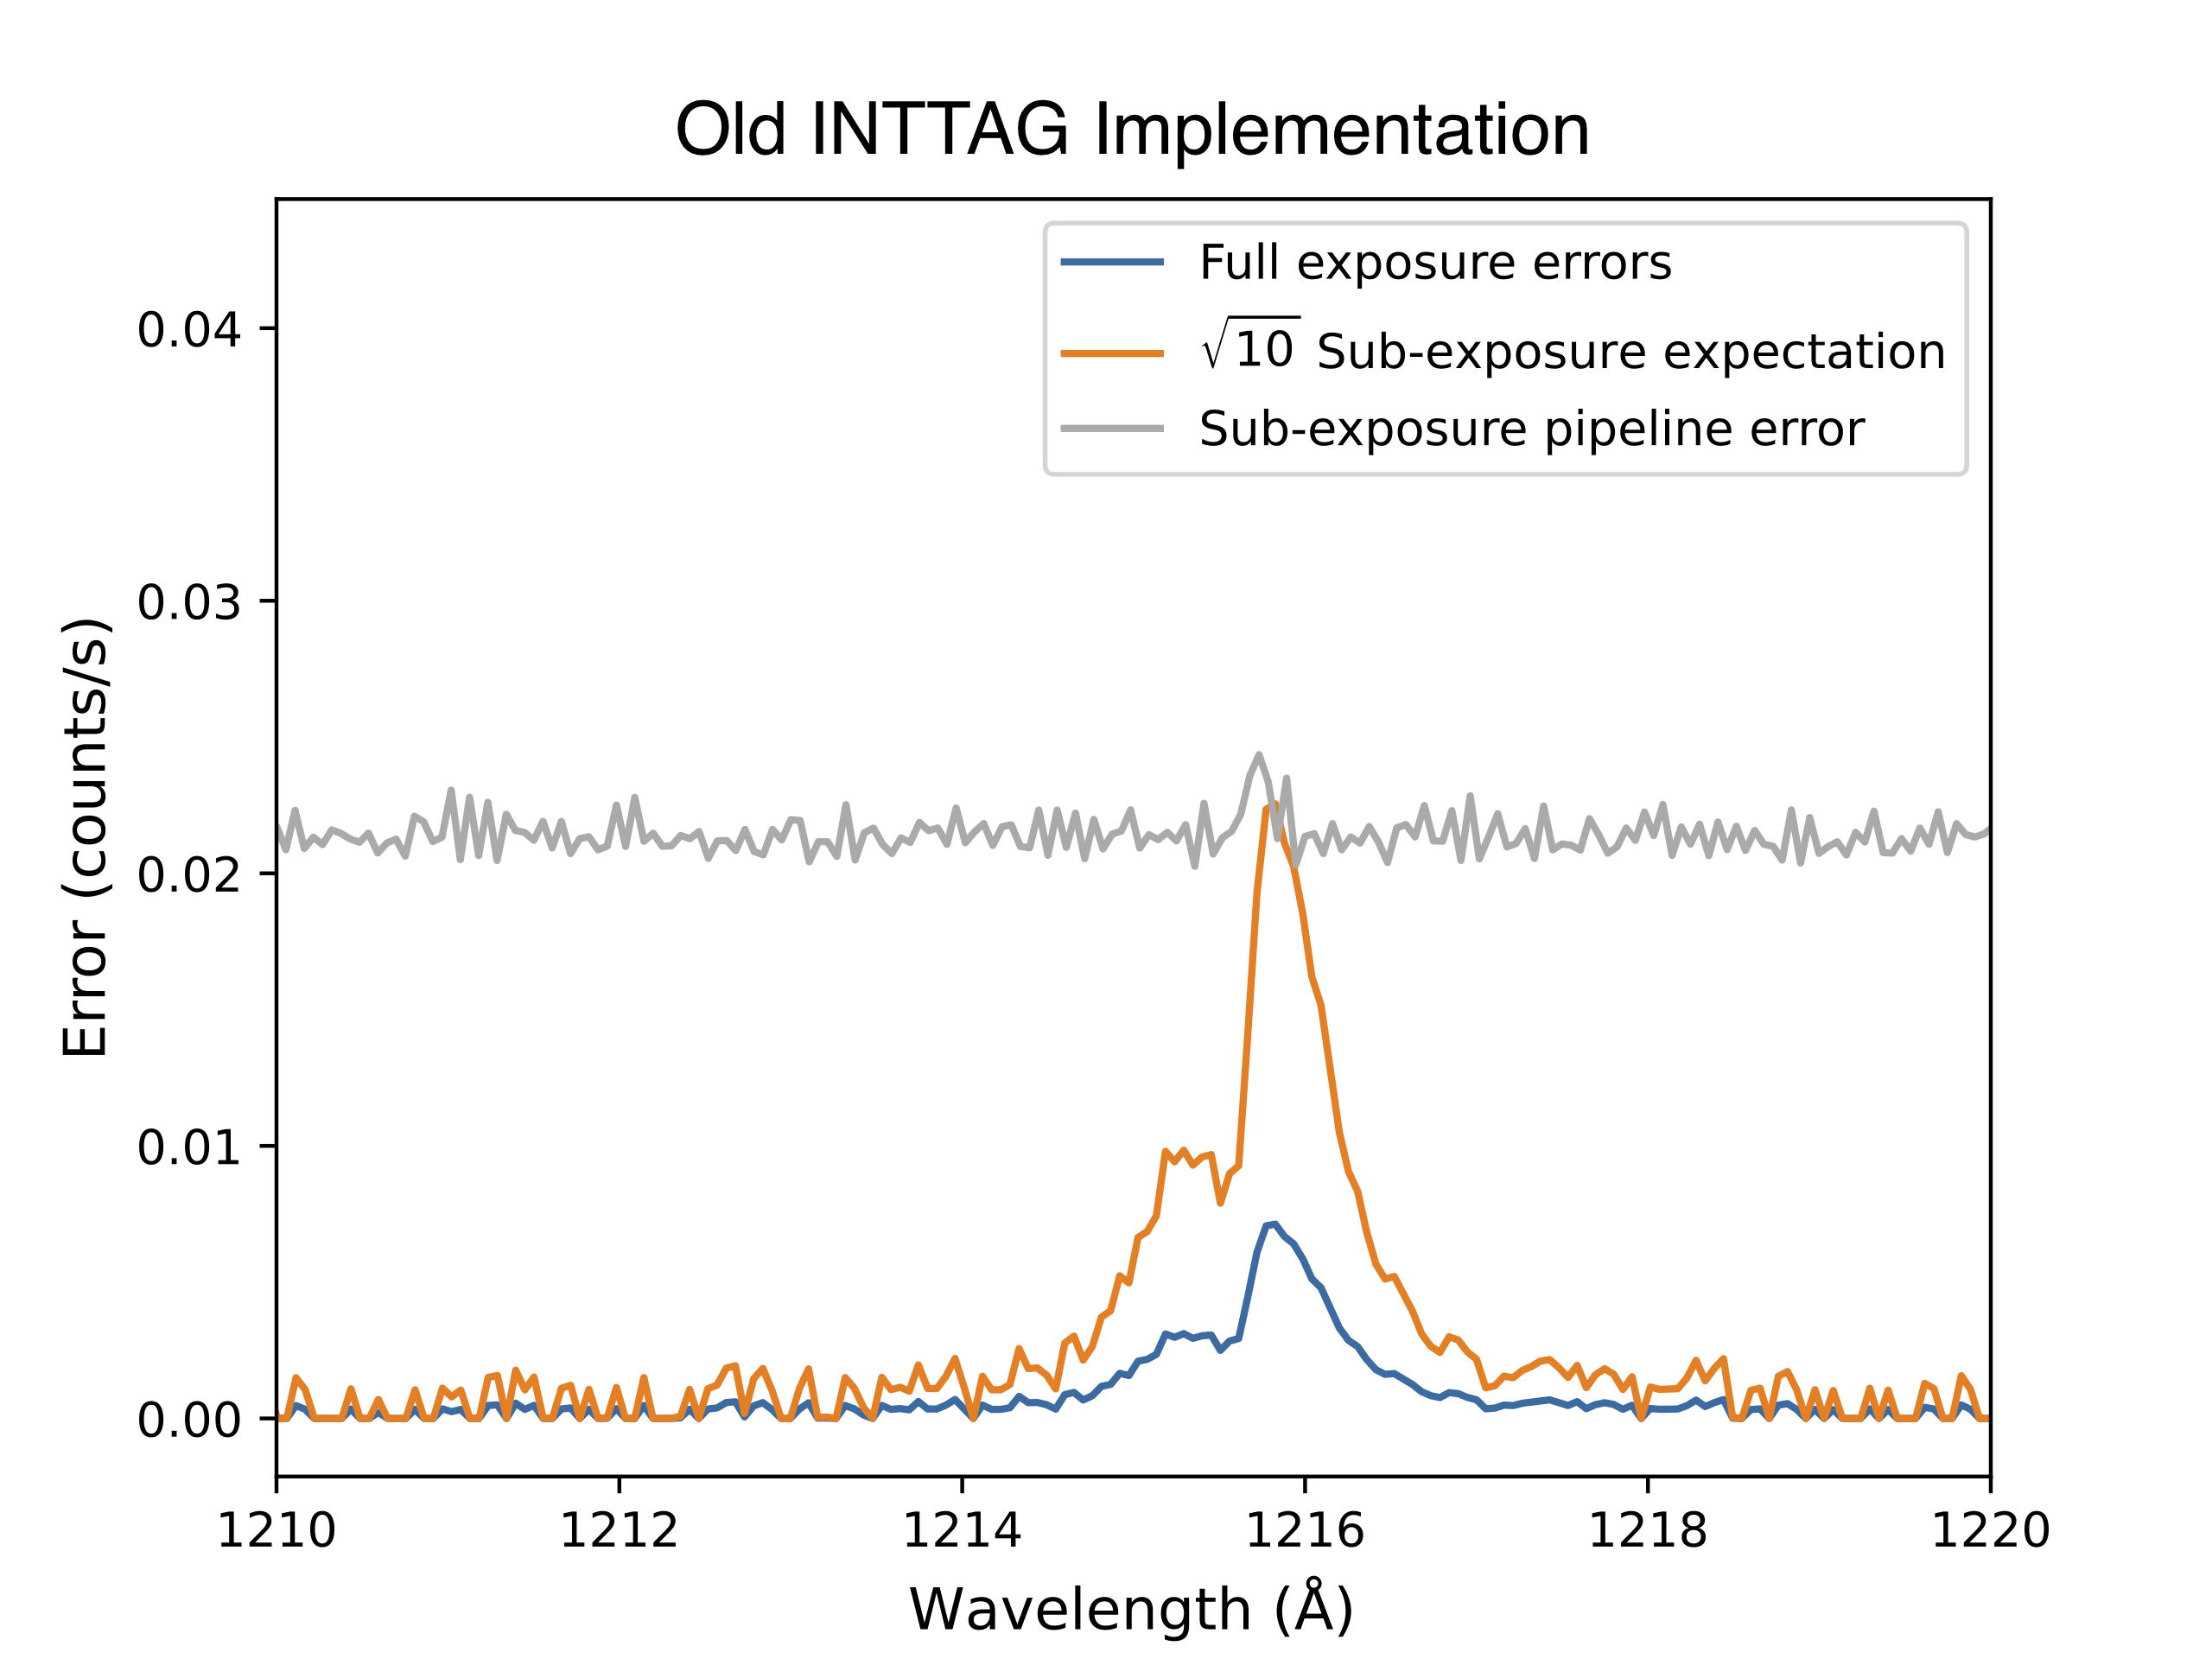

In [17]:
Image(filename="STIS_GJ436b_inttag.png", width=600, height=600)

Upon further inspection, it was found that this bug was related to these Poisson confidence intervals! When `inttag` fills the error arrays for the sub-exposure, rather than taking the square-root of the counts (as the pipeline would normally do), *inttag* actually used to use Astropy's poisson_confidence_interval. Unfortunately, `inttag` uses the incorrect method, choosing "sherpagehrels" over the more correct "frequentist-confidence". As we explored above, "sherpagehrels" actually gives symmetric lower and upper bounds, fixed to the upper bound calculated in [Gehrels (1986)](https://ui.adsabs.harvard.edu/abs/1986ApJ...303..336G/abstract). This was probably originally done because there was only room for one value in the error array, so the more conservative upper confidence interval was chosen. 

Furthermore, the Poisson errors are calculated at the pixel level, rather than after spectral extraction where the counts have been added up along columns. In the root-N approximation, this doesn't matter, because adding the root-N errors in quadrature is equivalent to taking the square root of the summed column:

$\sqrt{\sum_i{(\sqrt{n_i})^2}} = \sqrt{\sum_i{n_i}} = \sqrt{N}$,

where $n_i$ is the count measured on the $i$th pixel of a column and $N$ is the count for the entire column. In other words, it doesn't matter how the counts are arranged on a pixel column, all that matters is their sum. **But this is not true for Poisson errors.** Whether all your counts are centered on one pixel or whether your counts are distributed evenly accross your extraction window will change what the uncertainty on your spectrum is! 

You can see that in the following example, where we have to scenarios for how the flux is distributed along a column: either all the flux is in one pixel or it is evenly distributed. We then calculate the uncertainty on the extracted flux using the root-N approximation, first adding the error of each pixel in quadrature and then by summing the column and *then* calculating the error. These two methods give the same answer in both scenarios.

Then, we do the same thing but using Poisson confidence intervals with `astropy`. Now, when we calculate the errors pixel-by-pixel or on the extracted flux, we get different answers depending on how the counts are distributed and depending on how we add them up!

In [18]:
# Take two scenarios for how the counts are distributed across
# a fictional extraction window (i.e., column)
scenario1 = [0, 0, 10, 0, 0]
scenario2 = [2, 2, 2, 2, 2]


# define helper functions for the following print statements
def quadrature(scenario):
    return np.sqrt(np.sum([np.sqrt(i)**2 for i in scenario]))


def sum_sq(scenario):
    return np.sqrt(np.sum(scenario))


def pixel_err(scenario):
    return np.sqrt(np.sum(
        [(poisson_conf_interval(i, interval='frequentist-confidence')[1]-i)**2
         for i in scenario]))


def upper_err(scenario):
    return (poisson_conf_interval(
            np.sum(scenario), interval='frequentist-confidence')[1]
            - np.sum(scenario))


# Print the errors calculated in the various scenarios
print('Scenario 1: ', scenario1)
print('Scenario 2: ', scenario2)
print('---')
print('Root-N Approximation')
print('---')
print('Scenario 1')
print('---')
print('Root-N approximation, add in quadrature: ', quadrature(scenario1))
print('Root-N approximation, sum column, then take sqrt: ', sum_sq(scenario1))
print('---')
print('Poisson, pixel-by-pixel error calculation: ', pixel_err(scenario1))
print('Poisson upper limit, sum column, then calculate error: ',
      upper_err(scenario1))
print('---')
print('Scenario 2')
print('---')
print('Root-N approximation, add in quadrature: ', quadrature(scenario2))
print('Root-N approximation, sum column, then take sqrt: ', sum_sq(scenario2))
print('---')
print('Poisson, pixel-by-pixel error calculation: ', pixel_err(scenario2))
print('Poisson upper limit, sum column, then calculate error: ',
      upper_err(scenario2))

Scenario 1:  [0, 0, 10, 0, 0]
Scenario 2:  [2, 2, 2, 2, 2]
---
Root-N Approximation
---
Scenario 1
---
Root-N approximation, add in quadrature:  3.1622776601683795
Root-N approximation, sum column, then take sqrt:  3.1622776601683795
---
Poisson, pixel-by-pixel error calculation:  5.63598288256348
Poisson upper limit, sum column, then calculate error:  4.266949761009391
---
Scenario 2
---
Root-N approximation, add in quadrature:  3.1622776601683795
Root-N approximation, sum column, then take sqrt:  3.1622776601683795
---
Poisson, pixel-by-pixel error calculation:  5.898433433147927
Poisson upper limit, sum column, then calculate error:  4.266949761009391


**Recommendation:** In the end, our recommendation is to use the Poisson confidence intervals, but not at the pixel level because measurements along a column are not independent events. You would therefore be justified in calculating the Poisson confidence interval on the summed flux at each wavelength/column.

This bug has been fixed in `stistools.inttag` [here](https://github.com/spacetelescope/stistools/tree/sl_inttag-errors).

---
## About this Notebook <a class="tocSkip">
**Author:** [Joshua Lothringer](jlothringer@stsci.edu) with help from [Leo dos Santos](ldsantos@stsci.edu)

**Updated On:** 2025-04-10


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations <a class="tocSkip">

If you use `astropy`, `matplotlib`, `astroquery`, `scipy`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `scipy`](https://scipy.org/citing-scipy/)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)

---

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 